# Andres Avila EMPLID 24005404
### This codebook includes data visualizations and the report

In [208]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import LabelEncoder
import networkx as nx

In [241]:
orders_df = pd.read_csv("datasets/orders.csv")
order_product_df = pd.read_csv("datasets/order_products__train.csv")
aisles_df = pd.read_csv("datasets/aisles.csv")
department_df = pd.read_csv("datasets/departments.csv")
products_df = pd.read_csv("datasets/products.csv")

In [223]:
orders_products = pd.merge(orders_df, order_product_df, on='order_id')
products_details = pd.merge(products_df, aisles_df, on='aisle_id').merge(department_df, on='department_id')
full_data = pd.merge(orders_products, products_details, on='product_id') 
full_data.dropna()
#the best way I can think of merging this dataset


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7,soft drinks,beverages
1,1187899,1,train,11,4,8,14.0,25133,2,1,Organic String Cheese,21,16,packaged cheese,dairy eggs
2,1187899,1,train,11,4,8,14.0,38928,3,1,0% Greek Strained Yogurt,120,16,yogurt,dairy eggs
3,1187899,1,train,11,4,8,14.0,26405,4,1,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,1187899,1,train,11,4,8,14.0,39657,5,1,Milk Chocolate Almonds,45,19,candy chocolate,snacks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,272231,206209,train,14,6,14,30.0,40603,4,0,Fabric Softener Sheets,75,17,laundry,household
1048571,272231,206209,train,14,6,14,30.0,15655,5,0,Dark Chocolate Mint Snacking Chocolate,45,19,candy chocolate,snacks
1048572,272231,206209,train,14,6,14,30.0,42606,6,0,Phish Food Frozen Yogurt,37,1,ice cream ice,frozen
1048573,272231,206209,train,14,6,14,30.0,37966,7,0,French Baguette Bread,112,3,bread,bakery


In [211]:
# Calculate the number of items per single order for each user
items_per_order = full_data.groupby(['user_id', 'order_id']).size().reset_index(name='items_per_order')

# Average items per order (not very meaningful with one order per user but shows the approach)
average_items_per_user = items_per_order.groupby('user_id')['items_per_order'].mean().reset_index(name='average_items_per_order')

# Print results
print(average_items_per_user.head())

average_items_per_user['average_items_per_order'].value_counts()
item_counts = average_items_per_user['average_items_per_order'].value_counts().sort_index()
item_counts_df = item_counts.reset_index()
item_counts_df.columns = ['Items_Per_Order', 'Count']

   user_id  average_items_per_order
0        1                     11.0
1        2                     31.0
2        5                      9.0
3        7                      9.0
4        8                     18.0


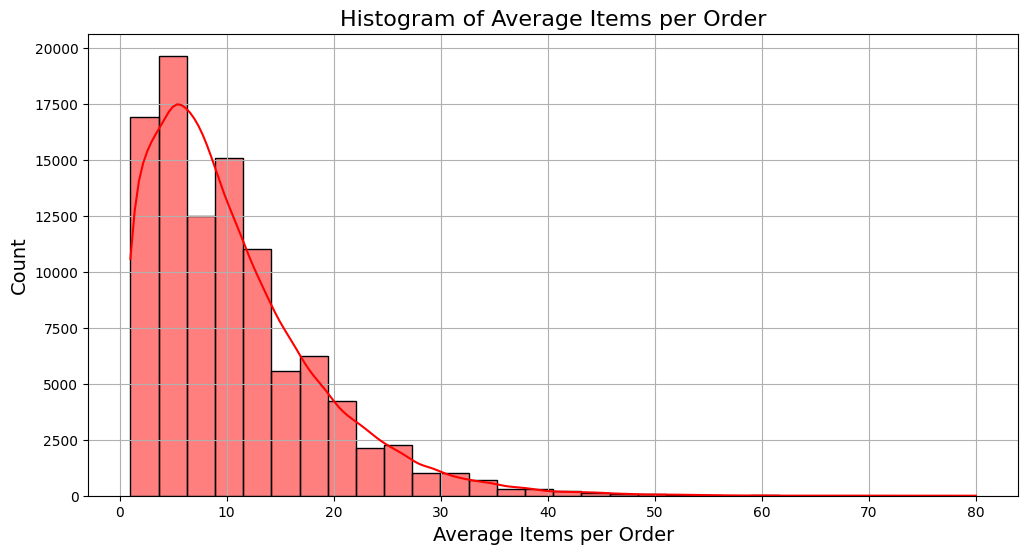

In [212]:
""" I went with this approach since plotting the individual
values will be overfitting for x-tickers in bar plots. I used a histogram that 
automatically places avg values into bins. """

plt.figure(figsize=(12, 6))
sns.histplot(data=average_items_per_user, x='average_items_per_order', bins=30, kde=True, color='red')
plt.title('Histogram of Average Items per Order', fontsize=16)
plt.xlabel('Average Items per Order', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)  
plt.show()


### This histogram helps me understand the distribution of average items per order within a dataset, revealing the typical shopping habits of customers. From the graph, I can see that most orders contain between 5 to 10 items, as indicated by the peak of the histogram. The distribution appears right-skewed, meaning that while the majority of the orders are clustered around a relatively lower number of items, there are still a significant number of orders that include more items, stretching up to 80 items per order.

In [88]:
# Calculate reorder count per user, for further insight about the data 
reorder_count = full_data.groupby('user_id')['reordered'].sum().reset_index(name='reorder_count')
reorder_count.describe()

,user_id,reorder_count
count,131209.000000,131209.000000
mean,103166.825317,6.316823
std,59565.307804,5.949995
min,1.000000,0.000000
25%,51587.000000,2.000000
50%,103150.000000,5.000000
75%,154868.000000,9.000000
max,206209.000000,71.000000


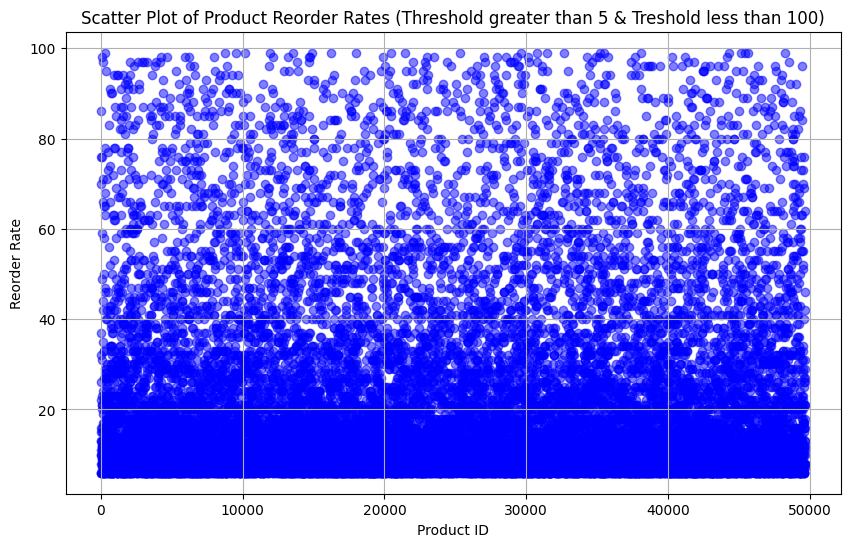

In [9]:
# Calculate reorder rate for each product
product_reorder_rates = full_data.groupby(['product_id'])['reordered'].count().reset_index(name='reorder_rate')
# Convert reorder_rate to integer for filtering
product_reorder_rates['reorder_rate'] = product_reorder_rates['reorder_rate'].astype(int)

# Filter out products with a reorder_rate of less than 5
filtered_products = product_reorder_rates[(product_reorder_rates['reorder_rate'] > 5) & 
                                          (product_reorder_rates['reorder_rate'] < 100)]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_products['product_id'], filtered_products['reorder_rate'], alpha=0.5, color='blue')
plt.title('Scatter Plot of Product Reorder Rates (Threshold greater than 5 & Treshold less than 100)')
plt.xlabel('Product ID')
plt.ylabel('Reorder Rate')
plt.grid(True)
plt.show()



## This scatter plot is a part of the EDA process. It visually represents each product's reorder rate, allowing us to quickly identify patterns or outliers. The plot shows a vast number of products distributed across various reorder rates, with a noticeable density in products having reorder rates between 20% and 60%. This distribution indicates that while many products are reordered at a moderate rate, there are also clusters of products with exceptionally high or low reorder rates.

In [11]:
# Group by user_id and order_id and filter groups with at least 5 items
items_per_order = full_data.groupby(['user_id', 'order_id']).size().reset_index(name='items_per_order')
filtered_orders = items_per_order[items_per_order['items_per_order'] >= 5]

# Filter the full_data to only include orders that meet the criteria
filtered_full_data = full_data.merge(filtered_orders[['user_id', 'order_id']], on=['user_id', 'order_id'])
filtered_full_data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7,soft drinks,beverages
1,1187899,1,train,11,4,8,14.0,25133,2,1,Organic String Cheese,21,16,packaged cheese,dairy eggs
2,1187899,1,train,11,4,8,14.0,38928,3,1,0% Greek Strained Yogurt,120,16,yogurt,dairy eggs
3,1187899,1,train,11,4,8,14.0,26405,4,1,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,1187899,1,train,11,4,8,14.0,39657,5,1,Milk Chocolate Almonds,45,19,candy chocolate,snacks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306060,272231,206209,train,14,6,14,30.0,40603,4,0,Fabric Softener Sheets,75,17,laundry,household
1306061,272231,206209,train,14,6,14,30.0,15655,5,0,Dark Chocolate Mint Snacking Chocolate,45,19,candy chocolate,snacks
1306062,272231,206209,train,14,6,14,30.0,42606,6,0,Phish Food Frozen Yogurt,37,1,ice cream ice,frozen
1306063,272231,206209,train,14,6,14,30.0,37966,7,0,French Baguette Bread,112,3,bread,bakery


In [12]:
# Create a list of products for each order, to encode
transactions = filtered_full_data.groupby(['user_id', 'order_id'])['product_id'].apply(list).tolist()
encoder = TransactionEncoder() ### easier to handle when dealing with apriori, quicker computations.
transaction_array = encoder.fit_transform(transactions)
transaction_df = pd.DataFrame(transaction_array, columns=encoder.columns_)
min_support = 0.005
## this was difficult to get right.. overall
frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)

In [145]:
frequent_itemsets

,support,itemsets,itemsets_names
0,0.006045,(45),[European Cucumber]
1,0.008358,(196),[Soda]
2,0.011792,(260),[Cantaloupe]
3,0.011891,(432),[Vanilla Almond Breeze Almond Milk]
4,0.005132,(651),[Organic Salted Butter]
...,...,...,...
530,0.013291,"(47626, 47766)","[Large Lemon, Organic Avocado]"
531,0.005817,"(13176, 21137, 21903)","[Bag of Organic Bananas, Organic Strawberries,..."
532,0.006442,"(13176, 21137, 27966)","[Bag of Organic Bananas, Organic Strawberries,..."
533,0.007038,"(13176, 47209, 21137)","[Bag of Organic Bananas, Organic Hass Avocado,..."


### To begin analyzing the Instacart grocery orders dataset, which comprises over 3 million orders from more than 200,000 users, I first focused on preprocessing the data. I filtered orders to include only those with at least five items, as these represent more substantial shopping trips likely to provide richer insights into customer buying habits. By grouping these filtered orders by `user_id` and `order_id` and listing the products purchased, I applied the Apriori algorithm to identify frequent itemsets, setting a support threshold to highlight commonly purchased items and item combinations. This methodological approach enables the identification of patterns that assist in clustering customer behaviors, which in turn facilitates the derivation of actionable insights, such as targeted marketing strategies or inventory adjustments, based on the observed shopping patterns.

### The reason why min_support value is so slow is because there are so many single transactions with 1 or 2 products in the dataset, thus we need a very low min_support values to capture any frequent itemsets occurring in transactions.  
### (geeksforgeeks definition): 
#### MBA, support is a measure of how frequently an itemset appears in the dataset of transactions. It is calculated as the proportion of transactions that contain a particular itemset among all transactions.

In [173]:
rules= association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
rules = rules.sort_values(by='lift', ascending=False)  # Sort rules by lift, to my understanding it is re-arranging the confidence from greatest to least

product_mapping = products_df.set_index('product_id')['product_name'].to_dict() # this should have the product_id as the key and the value as the product name.
# Function to replace sets of product IDs with names

def decode_product_names(product_set): #helper function, for retrieving product names, their encoded labels are meaningless
    return frozenset([product_mapping[id] for id in product_set])

rules['antecedents_names'] = rules['antecedents'].apply(lambda x: decode_product_names(list(x)))
rules['consequents_names'] = rules['consequents'].apply(lambda x: decode_product_names(list(x)))

# Showing decoded rules, according to documentation....
print(rules[['antecedents_names', 'consequents_names', 'support', 'confidence', 'lift']].head())

          antecedents_names       consequents_names   support  confidence  \
195      (Bunched Cilantro)                 (Limes)  0.005489    0.298113   
88       (Jalapeno Peppers)                 (Limes)  0.005400    0.295652   
150  (Organic Yellow Onion)        (Organic Garlic)  0.008358    0.201773   
149        (Organic Garlic)  (Organic Yellow Onion)  0.008358    0.207850   
197                 (Limes)      (Organic Cilantro)  0.009936    0.170965   

         lift  
195  5.129533  
88   5.087187  
150  5.017934  
149  5.017934  
197  4.996770  


### The association rules extracted from transaction data highlight significant purchasing patterns, such as the frequent pairing of "Bunched Cilantro" with "Limes" and "Jalapeno Peppers" with "Limes." This insight suggests a common usage in specific cuisines, presenting an opportunity for cross-promotional campaigns and targeted marketing. For instance, stores can strategically place these items together or promote them in bundles, potentially increasing basket sizes. Similarly, the strong relationship between "Organic Yellow Onion" and "Organic Garlic" indicates a preference for organic ingredients among consumers, suggesting that stores could enhance the shopping experience by arranging these items near each other in the organic section and providing recipe suggestions that use both. Additionally, understanding these pairings helps in managing inventory effectively, ensuring that these products are well-stocked to meet customer demand, particularly during promotions or peak shopping times. By leveraging such insights, retailers can not only improve sales but also enhance customer satisfaction and loyalty by making shopping more convenient and tailored to consumer preferences.

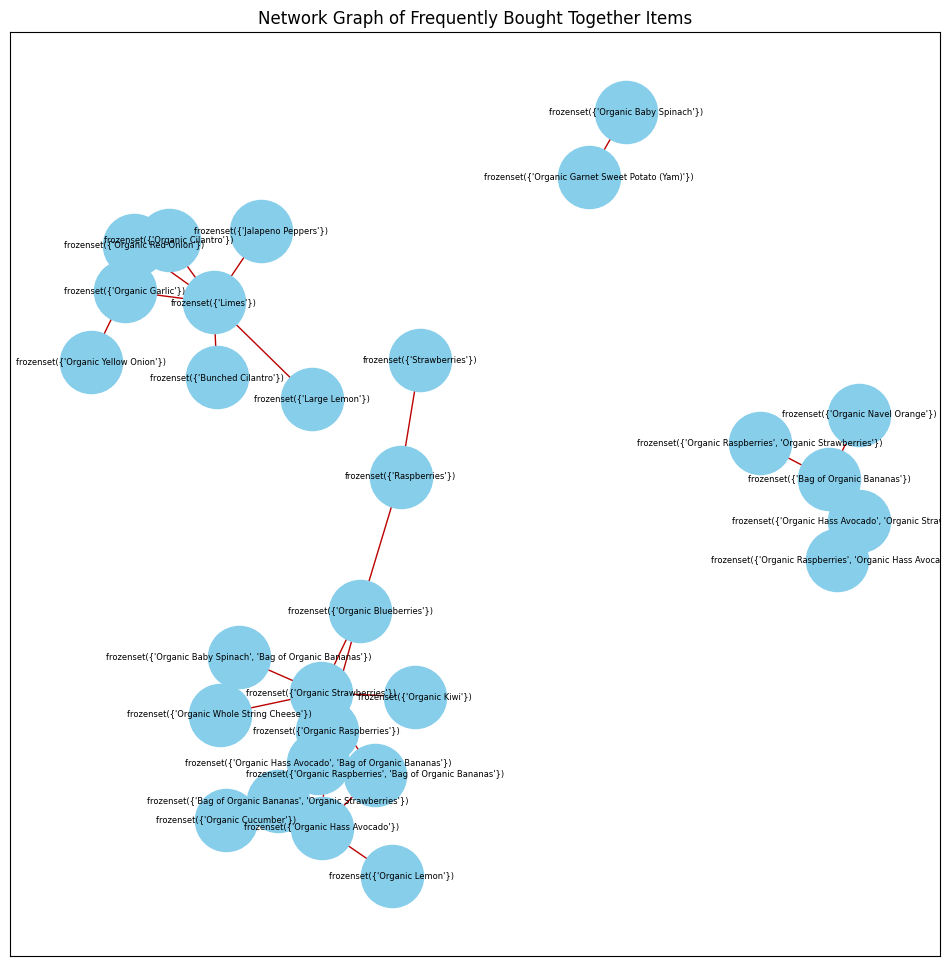

In [174]:
# Decode antecedents and consequents in the rules DataFrame
rules['antecedents'] = rules['antecedents'].apply(decode_product_names) #re-define again for our graph
rules['consequents'] = rules['consequents'].apply(decode_product_names)


G = nx.from_pandas_edgelist(rules.head(50), 'antecedents', 'consequents', edge_attr=True)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.35, iterations=50) #adjust the k value, this will push the nodes further apart, and reduce label overlapping :)

nx.draw_networkx(G, pos, edge_color="#BB0000", node_color="skyblue", with_labels=True, node_size=2000, font_size=6)
plt.title('Network Graph of Frequently Bought Together Items')
plt.show()
##this was all from the nx documentation
# ref: https://networkx.org/documentation/stable/tutorial.html

## Interpretation and Visualization of Clusters 
From the graph, it's evident that certain organic products, like "Organic Avocado" and "Bag of Organic Bananas," frequently appear together. This clustering suggests a segment of health-conscious consumers or those preferring organic produce. Identifying such clusters helps in targeting these customer segments more effectively with promotions or personalized recommendations 

Providing Actionable Business Insights Based on the Segme ts
With the knowledge of these purchasing clusters, a grocery store or online retailer can create bundled offers or discounts on frequently bought together items to increase basket sizes and enhance customer satisfaction. For example, offering a discount on "Organic Strawberries" when purchased with "Organic Bananas" could incentivize customers to buy both, boosting sales and enhancing customer reten, also it shows an emergering demand in organic foods, could be a worth while investmentt n.

Additionally, inventory management can be optimized by ensuring that items frequently bought together are always stocked and placed near each other in physical or virtual stores to enhance the shopping experience.

In [157]:
frequent_itemsets['itemsets_names'] = frequent_itemsets['itemsets'].apply(decode_product_names) #apply function
#showing results
print(frequent_itemsets[['itemsets', 'itemsets_names']]) #individual itemsets shown below

                  itemsets                                     itemsets_names
0                     (45)                                (European Cucumber)
1                    (196)                                             (Soda)
2                    (260)                                       (Cantaloupe)
3                    (432)                (Vanilla Almond Breeze Almond Milk)
4                    (651)                            (Organic Salted Butter)
..                     ...                                                ...
530         (47626, 47766)                     (Large Lemon, Organic Avocado)
531  (13176, 21137, 21903)  (Organic Baby Spinach, Bag of Organic Bananas,...
532  (13176, 21137, 27966)  (Organic Raspberries, Bag of Organic Bananas, ...
533  (13176, 47209, 21137)  (Organic Hass Avocado, Bag of Organic Bananas,...
534  (13176, 47209, 27966)  (Organic Raspberries, Organic Hass Avocado, Ba...

[535 rows x 2 columns]


In [197]:
#here is a sample; adjust the slicing index, to view different itemsets  (535 rows in total)
for index, row in frequent_itemsets[15:20].iterrows():
    print(f"Itemset {index + 1}:")
    print("Product IDs:", row['itemsets'])
    print("Product Names:", ", ".join(row['itemsets_names']))
    print("\n")


Itemset 16:
Product IDs: frozenset({3599})
Product Names: Baked Aged White Cheddar Rice and Corn Puffs


Itemset 17:
Product IDs: frozenset({3952})
Product Names: Organic Broccoli Crowns


Itemset 18:
Product IDs: frozenset({3957})
Product Names: 100% Raw Coconut Water


Itemset 19:
Product IDs: frozenset({4210})
Product Names: Whole Milk


Itemset 20:
Product IDs: frozenset({4472})
Product Names: Toasted Coconut Almondmilk Blend




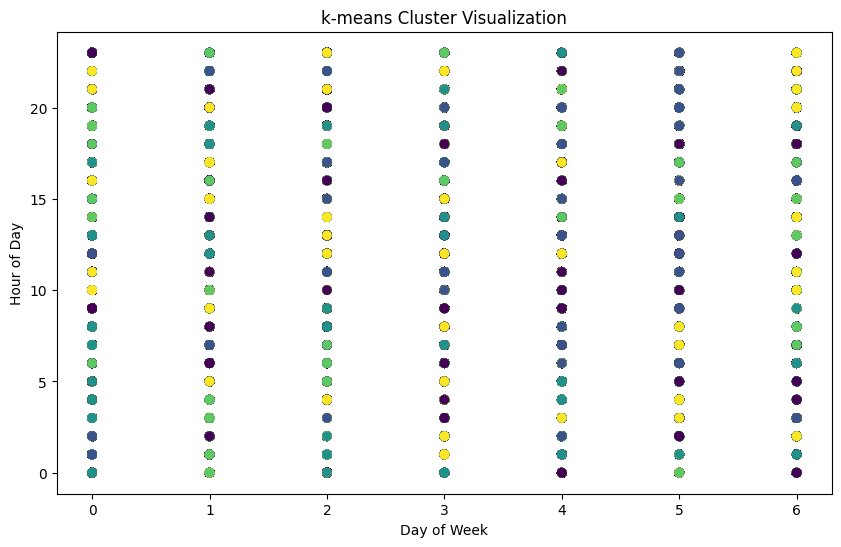

         order_dow  order_hour_of_day  days_since_prior_order    product_id  \
cluster                                                                       
0         2.684202          13.595529               16.971453  24936.994717   
1         2.714725          13.590485               17.046113   5417.057390   
2         2.687705          13.606016               17.088962  45039.847666   
3         2.712265          13.572659               17.008293  15283.164084   
4         2.718542          13.580265               17.076489  35047.096510   

         add_to_cart_order  reordered   aisle_id  department_id  
cluster                                                          
0                 8.572599   0.627842  71.717433       9.332831  
1                 8.884881   0.579691  71.388260      10.074953  
2                 8.857329   0.598055  71.362865       9.553088  
3                 8.585286   0.598240  70.530740      10.051448  
4                 8.828379   0.583432  71.480293  

In [213]:
#this should help prevent any runtime errors :
orders_products = pd.merge(orders_df, order_product_df, on='order_id')
products_details = pd.merge(products_df, aisles_df, on='aisle_id').merge(department_df, on='department_id')
full_data = pd.merge(orders_products, products_details, on='product_id') 
full_data.dropna()

label_encoder = LabelEncoder()
categorical_cols = ['product_name', 'aisle', 'department']
for col in categorical_cols:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# some of the feature selecting: 
features = ['order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered', 'aisle_id', 'department_id']
X = full_data[features]


# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
full_data['cluster'] = kmeans.labels_

# Cluster visualization
plt.figure(figsize=(10, 6))
plt.scatter(X['order_dow'], X['order_hour_of_day'], c=full_data['cluster'], cmap='viridis')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.title('k-means Cluster Visualization')
plt.show()

# Cluster analysis
cluster_analysis = full_data.groupby('cluster')[features].mean()
print(cluster_analysis)

# insights by retrieving the cluster with the highest reorder rate, by using idmax(); [everything else was giving me an issue]
highest_reorder_cluster = cluster_analysis['reordered'].idxmax() 
print(f"Cluster {highest_reorder_cluster} has the highest average reorder rate.") #the easiest way I can think of showing the results
cluster_insights = full_data[full_data['cluster'] == highest_reorder_cluster]
print(cluster_insights.head())

## The cluster visualization provides a clear graphical representation of how purchasing behaviors vary across different days of the week and hours of the day. It shows distinct clusters that represent varying shopping patterns, such as the time preferences for shopping by different segments of customers. For example, some clusters may show higher activity during early mornings on weekends, which could indicate a segment of early risers preparing for the week ahead. 
From the detailed clustering analysis, Cluster 2 stands out due to its highest average reorder rate. This indicates that customers within this cluster are more likely to reorder products, suggesting a higher level of satisfaction or a routine need for these products. The cluster analysis also reveals that this group tends to shop midweek and in the morning hours, potentially representing working adults who schedule routine restocking of essential 

The actionable business insights derived from this cluster analysis can guide targeted marketing strategies. Knowing that Cluster 2 has a higher likelihood to reorder, marketing efforts such as personalized emails or app notifications about stock updates or upcoming sales can be scheduled during midweek mornings to maximize impact. Additionally, understanding the specific products and departments that this cluster frequently shops can help in optimizing inventory levels and arranging store layouts to enhance the shopping experience for this custosegment. t.

Overall, leveraging this cluster information allows for more tailored marketing and operational strategies that align with the observed purchasing behaviors, enhancing customer satisfaction and potentially increasing sales through higher reorder rates.

In [214]:
#some additional info about cluster 2 
cluster_2_data = full_data[full_data['cluster'] == 2]
# Count the frequency of each product_id in Cluster 2
product_counts = cluster_2_data['product_id'].value_counts().reset_index()
product_counts.columns = ['product_id', 'frequency']
product_details = product_counts.merge(products_df, on='product_id', how='left')
# Display the top 10 most frequent products purchased in Cluster 2
print(full_data)

         order_id  user_id eval_set  order_number  order_dow  \
0         1187899        1    train            11          4   
1         1187899        1    train            11          4   
2         1187899        1    train            11          4   
3         1187899        1    train            11          4   
4         1187899        1    train            11          4   
...           ...      ...      ...           ...        ...   
1048570    272231   206209    train            14          6   
1048571    272231   206209    train            14          6   
1048572    272231   206209    train            14          6   
1048573    272231   206209    train            14          6   
1048574    272231   206209    train            14          6   

         order_hour_of_day  days_since_prior_order  product_id  \
0                        8                    14.0         196   
1                        8                    14.0       25133   
2                        8       

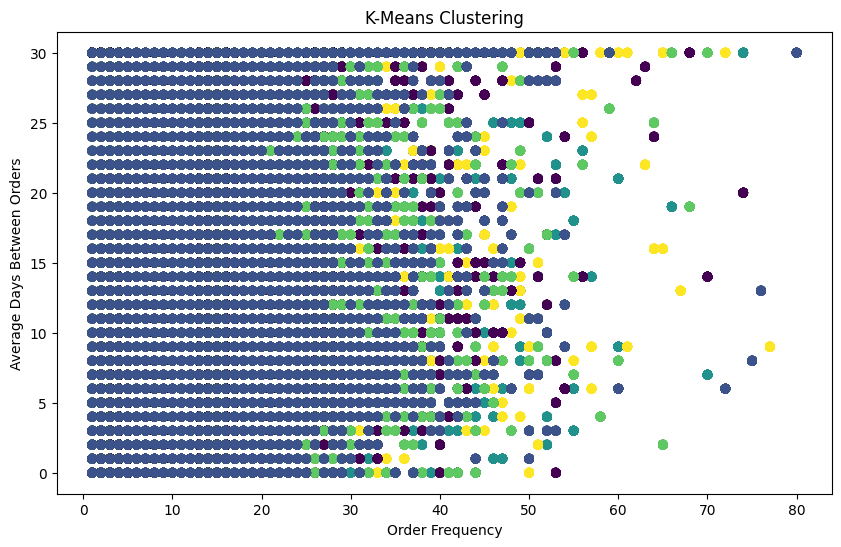

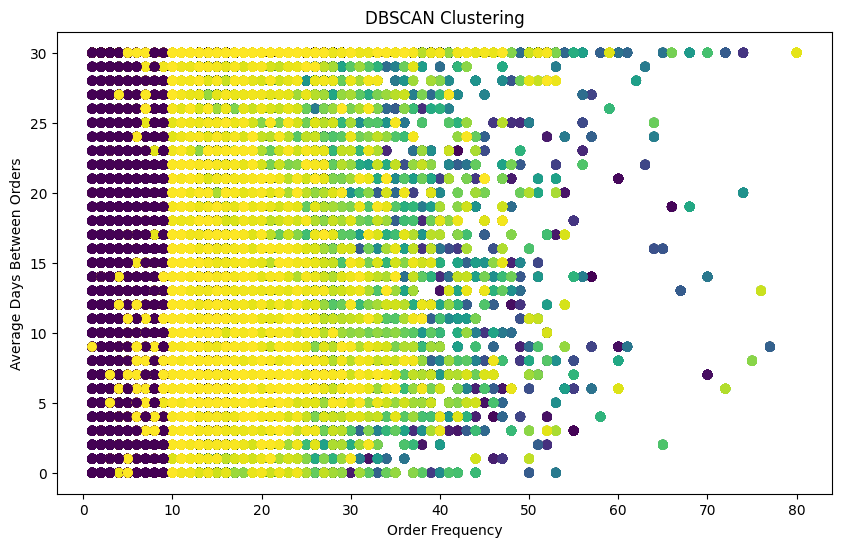

In [215]:
orders_products = pd.merge(orders_df, order_product_df, on='order_id')
products_details = pd.merge(products_df, aisles_df, on='aisle_id').merge(department_df, on='department_id')
full_data = pd.merge(orders_products, products_details, on='product_id') 
full_data.dropna() #we'll re- define this once again
#convert categorial to numerical 
full_data = full_data.copy()
label_encoder = LabelEncoder()
categorical_cols = ['product_name', 'aisle', 'department']
for col in categorical_cols:
    full_data[col] = label_encoder.fit_transform(full_data[col])


# Calculate order frequency for each user
order_frequency = full_data.groupby('user_id')['order_number'].count().reset_index()
order_frequency.columns = ['user_id', 'order_frequency']
full_data = pd.merge(full_data, order_frequency, on='user_id', how='left')

# Calculate average days between orders for each user
avg_days_between_orders = full_data.groupby('user_id')['days_since_prior_order'].mean().reset_index()
avg_days_between_orders.columns = ['user_id', 'avg_days_between_orders']
full_data = pd.merge(full_data, avg_days_between_orders, on='user_id', how='left')


# Select user-based features
user_features = ['user_id', 'order_frequency', 'avg_days_between_orders']
X = full_data[user_features]


# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
full_data['cluster_kmeans'] = kmeans.labels_

# DBSCAN clustering
dbscan = DBSCAN(eps=5, min_samples=10)
dbscan.fit(X)
full_data['cluster_dbscan'] = dbscan.labels_


# Visualize K-Means clusters
plt.figure(figsize=(10, 6))
plt.scatter(X['order_frequency'], X['avg_days_between_orders'], c=full_data['cluster_kmeans'], cmap='viridis')
plt.xlabel('Order Frequency')
plt.ylabel('Average Days Between Orders')
plt.title('K-Means Clustering')
plt.show()

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
plt.scatter(X['order_frequency'], X['avg_days_between_orders'], c=full_data['cluster_dbscan'], cmap='viridis')
plt.xlabel('Order Frequency')
plt.ylabel('Average Days Between Orders')
plt.title('DBSCAN Clustering')
plt.show()

## The high-frequency cluster insights derived from both K-Means and DBSCAN clustering indicate distinct patterns in customer purchasing behaviors that are essential for tailoring marketing strategies and improving service delivery. The clusters identified suggest a segment of users who place orders frequently and have shorter intervals between orders, highlighting a group of potentially high-value customers who are engaged and regular shoppers. 
For actionable insights, focusing on the needs and preferences of this segment could be highly beneficial. Personalized marketing strategies, such as targeted promotions on frequently purchased products or during specific hours they prefer to shopfor example , late mornings and mid-afternoons as suggested by the cluster data), could enhance customer loyalty and increase sales. Additionally, considering the frequent reorder rates in these clusters, implementing a loyalty program or offering benefits for consistent reorders could incentivize continued patronage. Understanding the specific departments and aisles these customers frequent could also guide inventory management to ensure high-demand items are always in stock, thus improving customer satisfaction and retention. Moreover, by analyzing the demographic and purchasing data from these clusters, further personalized experiences can be crafted to suit their unique shopping preferences and habits, ultimateldevelpong a stronger customer relationship.

In [216]:
# Analyze clusters with high order frequency and low average days between orders, I think this is a good dynamic.
high_frequency_clusters_kmeans = full_data[(full_data['cluster_kmeans'] == kmeans.labels_.max()) & (full_data['order_frequency'] > full_data['order_frequency'].mean())]
print("K-Means: High-frequency cluster insights:")
print(high_frequency_clusters_kmeans.head())

#DBSCAN too
high_frequency_clusters_dbscan = full_data[(full_data['cluster_dbscan'] == dbscan.labels_.max()) & (full_data['order_frequency'] > full_data['order_frequency'].mean())]
print("\nDBSCAN: High-frequency cluster insights:")
print(high_frequency_clusters_dbscan.head())

K-Means: High-frequency cluster insights:
        order_id  user_id eval_set  order_number  order_dow  \
203616   1409866    40474    train            30          0   
203617   1409866    40474    train            30          0   
203618   1409866    40474    train            30          0   
203619   1409866    40474    train            30          0   
203620   1409866    40474    train            30          0   

        order_hour_of_day  days_since_prior_order  product_id  \
203616                 11                    13.0       38949   
203617                 11                    13.0       35221   
203618                 11                    13.0       27726   
203619                 11                    13.0       16541   
203620                 11                    13.0        3990   

        add_to_cart_order  reordered  product_name  aisle_id  department_id  \
203616                  1          0         10848        60             17   
203617                  2     

In [240]:
popular_departments

[19, 3, 10]

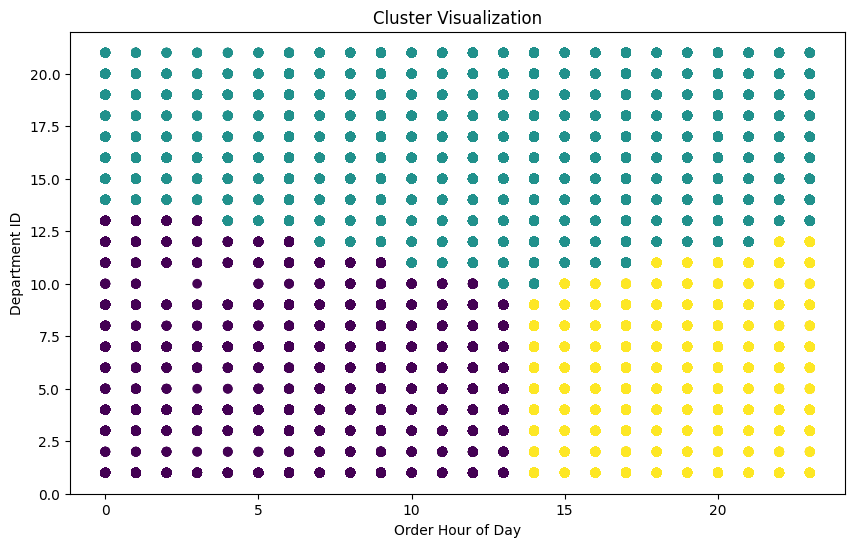

         department_id  order_hour_of_day
cluster                                  
0             4.463329          10.047442
1            16.174198          13.605678
2             4.386236          17.031401

Cluster 2 has the highest order volume during peak hours.
     order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
101   1822501       10    train             6          0                 19   
102   1822501       10    train             6          0                 19   
104   1827621       13    train            13          0                 21   
107   1827621       13    train            13          0                 21   
110   2316178       14    train            14          2                 19   

     days_since_prior_order  product_id  add_to_cart_order  reordered  \
101                    30.0       48720                  2          0   
102                    30.0       24654                  3          0   
104                     8.0       274

In [242]:
orders_products = pd.merge(orders_df, order_product_df, on='order_id')
products_details = pd.merge(products_df, aisles_df, on='aisle_id').merge(department_df, on='department_id')
full_data = pd.merge(orders_products, products_details, on='product_id') 
full_data.dropna() #we'll re- define this once again

label_encoder = LabelEncoder()
categorical_cols = ['product_name', 'aisle', 'department']
for col in categorical_cols:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# Select features for clustering
features = ['department_id', 'order_hour_of_day']
X = full_data[features]

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
full_data['cluster'] = kmeans.labels_

# Cluster visualization
plt.figure(figsize=(10, 6))
plt.scatter(X['order_hour_of_day'], X['department_id'], c=full_data['cluster'], cmap='viridis')
plt.xlabel('Order Hour of Day')
plt.ylabel('Department ID')
plt.title('Cluster Visualization')
plt.show()

# Cluster analysis
cluster_analysis = full_data.groupby('cluster')[features].mean()
print(cluster_analysis)

# Analyze clusters with high order volume during peak hours
peak_hours = full_data['order_hour_of_day'].value_counts().sort_index().index[16:24]  # Assuming peak hours are between 4 PM and 8 PM
peak_hour_clusters = full_data[(full_data['order_hour_of_day'].isin(peak_hours))]

if not peak_hour_clusters.empty:
    cluster_sizes = peak_hour_clusters.groupby('cluster')['order_id'].count()
# If there is data, we calculate the size of each cluster by counting the number of orders in each cluster. 
#This gives us a clear idea of which cluster is the busiest during peak times.

    highest_peak_hour_cluster = cluster_sizes.idxmax()
# We then identify the cluster with the maximum order volume. This cluster's behavior during peak hours can provide insights 
# into customer demand and help in planning resources effectively.
    
    print(f"\nCluster {highest_peak_hour_cluster} has the highest order volume during peak hours.")
#print
    cluster_details = peak_hour_clusters[peak_hour_clusters['cluster'] == highest_peak_hour_cluster]
# We check if the 'peak_hour_clusters' dataframe is empty. This step is important because it ensures there's data to analyze,
    
    print(cluster_details.head())
# We print high peak hours from cluster df, assuming there is a result....
    department_df = pd.read_csv("datasets/departments.csv")
    department_mapping = department_df.set_index('department_id')['department'].to_dict()#mapping

    # Get the most popular department IDs
    popular_department_ids = cluster_details['department_id'].value_counts().head(3).index
    # Translate department IDs to names using the mapping dictionary
    popular_departments = [department_mapping[dept_id] for dept_id in popular_department_ids]
    
 # Analyze the most popular departments during peak hours
    print("\nMost popular departments during peak hours:")
    print(popular_departments)
else:
    print("\nNo cluster meets the criteria for highest order volume during peak hours.")
#this took a bit of time to get right

### The analysis of Cluster 2 reveals a significant trend of shopping activity during late evening hours, particularly around 19:00 to 21:00, with a notable focus on departments such as 'produce', 'beverages', and 'frozen'. This pattern suggests a post-work shopping behavior that can be strategically targeted to boost customer engagement and optimize sales. Tailoring promotions or discounts specifically during these peak times could effectively draw more traffic from this department, we can take advantage of this information. Furthermore, an strategy can be imposed that includes optimizing stocking inventory frequency to prevent stockouts (items not available on shelves) and adjusting staffing to meet increased demand during these hours could enhance the shopping experience for the average consumer. 







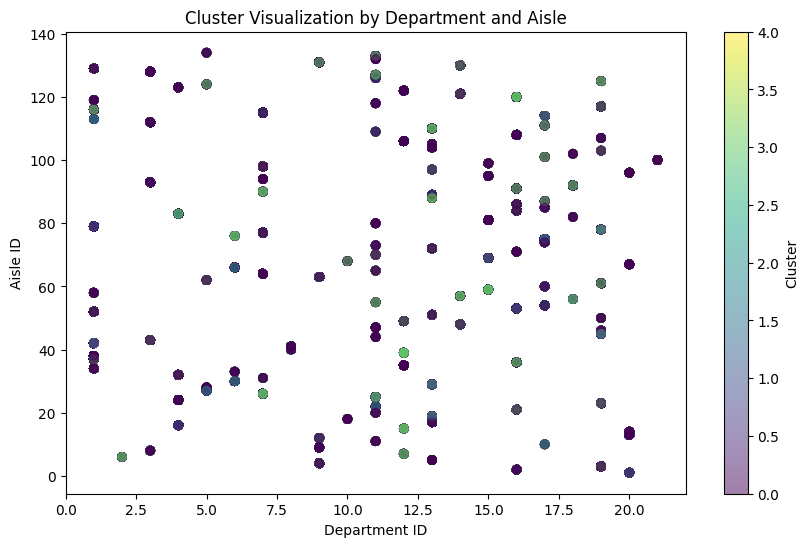

Department Cluster Analysis:
department_id        1         2         3         4         5         6   \
cluster                                                                     
0              0.457802  0.010641  0.203661  1.623025  0.052759  0.034663   
1              2.286865  0.026777  1.105983  4.081079  0.058047  0.178073   
2              1.038758  0.020004  0.388623  4.398833  0.020213  0.126693   
3              0.853808  0.014386  0.476587  6.781022  0.010384  0.202734   
4              0.895385  0.021538  0.332308  3.169231  0.064615  0.187692   

department_id        7         8         9         10  ...        12  \
cluster                                                ...             
0              0.717806  0.028116  0.109309  0.004365  ...  0.099035   
1              1.940081  0.099523  0.894392  0.008426  ...  0.472802   
2              1.077516  0.042092  0.322984  0.016253  ...  0.269640   
3              0.724765  0.017530  0.535893  0.028200  ...  0.490544   

In [227]:
orders_products = pd.merge(orders_df, order_product_df, on='order_id')
products_details = pd.merge(products_df, aisles_df, on='aisle_id').merge(department_df, on='department_id')
full_data = pd.merge(orders_products, products_details, on='product_id') 
full_data.dropna() #we'll re- define this once again

label_encoder = LabelEncoder()
categorical_cols = ['product_name', 'aisle', 'department']
for col in categorical_cols:
    full_data[col] = label_encoder.fit_transform(full_data[col])

#  Feature selection 
user_dept_spend = full_data.groupby(['user_id', 'department_id'])['product_id'].count().unstack(fill_value=0)
user_aisle_spend = full_data.groupby(['user_id', 'aisle_id'])['product_id'].count().unstack(fill_value=0)

# Combine user-department and user-aisle spend data
X = pd.concat([user_dept_spend, user_aisle_spend], axis=1).fillna(0)

# 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Implementation of clustering algorithms
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Safely adding cluster labels back to the original data
full_data = full_data.loc[X.index]  # Ensure the indices match, I was having difficulty with this.
full_data['cluster'] = labels

# visualization of clusters
plt.figure(figsize=(10, 6))
plt.scatter(full_data['department_id'], full_data['aisle_id'], c=full_data['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Department ID')
plt.ylabel('Aisle ID')
plt.title('Cluster Visualization by Department and Aisle')
plt.colorbar(label='Cluster')
plt.show()

# Prepare data by adding cluster labels to user_dept_spend and user_aisle_spend for detailed analysis
user_dept_spend['cluster'] = labels
user_aisle_spend['cluster'] = labels

# Aggregate data to understand spend pattern within clusters
dept_cluster_analysis = user_dept_spend.groupby('cluster').mean()
aisle_cluster_analysis = user_aisle_spend.groupby('cluster').mean()

print("Department Cluster Analysis:")
print(dept_cluster_analysis)
print("Aisle Cluster Analysis:")
print(aisle_cluster_analysis)

# Identify the cluster with the highest engagement or total transactions
highest_spend_cluster = dept_cluster_analysis.sum(axis=1).idxmax()
print(f"Cluster {highest_spend_cluster} has the highest engagement based on total transactions.")


#Print for actionable insights
print("\nActionable Business Insights:")
print("~ Focus marketing efforts on the most active departments and aisles in Cluster", highest_spend_cluster)
print("~ Customize promotions and product placements based on the unique shopping patterns observed in Cluster", highest_spend_cluster)


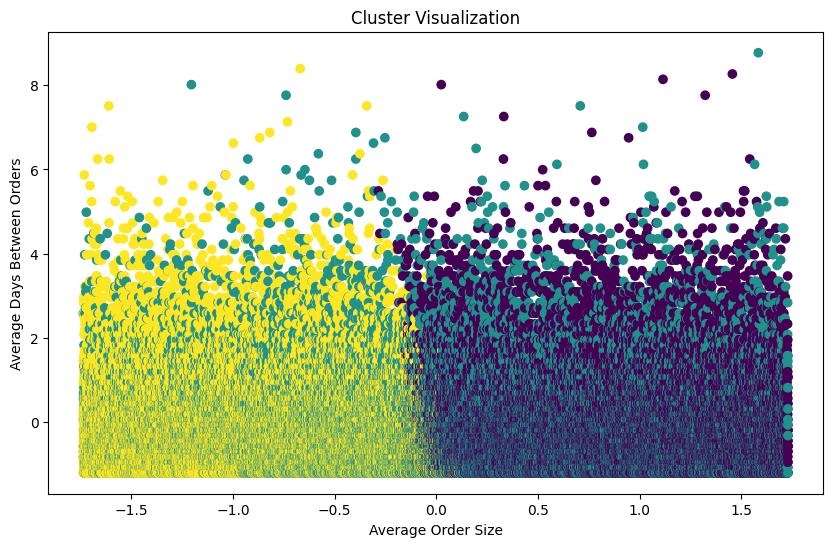

Cluster Analysis:
              User ID        user_id  avg_order_size  avg_days_between_orders  \
Cluster                                                                         
0        74697.785387  154824.874068        5.942919                 8.922989   
1        52103.358840  108096.610280        5.682004                28.336136   
2        22653.275076   47135.038048        5.697989                10.651948   

         reorder_rate  
Cluster                
0            0.678715  
1            0.464377  
2            0.703921  

Cluster 5 has the highest reorder rate.
Average Order Size for Highest-Reorder Cluster: 5.77
Average Days Between Orders: 17.04


In [232]:
orders_products = pd.merge(orders_df, order_product_df, on='order_id')
products_details = pd.merge(products_df, aisles_df, on='aisle_id').merge(department_df, on='department_id')
full_data = pd.merge(orders_products, products_details, on='product_id') 
full_data.dropna() #we'll re- define this once again

#repeating the same process as before , feature selection and data aggregation are different for each cluster, 
# so that we can provide a comprehensive insight into this supermarket business.
label_encoder = LabelEncoder()
categorical_cols = ['product_name', 'aisle', 'department']
for col in categorical_cols:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# Calculate average order size for each user
user_avg_order_size = full_data.groupby('user_id')['add_to_cart_order'].mean().reset_index()
user_avg_order_size.columns = ['user_id', 'avg_order_size']

# Calculate average days between orders for each user
user_avg_days_between_orders = full_data.groupby('user_id')['days_since_prior_order'].mean().reset_index()
user_avg_days_between_orders.columns = ['user_id', 'avg_days_between_orders']

# Calculate reorder rate for each user
user_reorder_rate = full_data.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_rate.columns = ['user_id', 'reorder_rate']

# Combine user features
X = pd.merge(user_avg_order_size, user_avg_days_between_orders, on='user_id')
X = pd.merge(X, user_reorder_rate, on='user_id')

# 3. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Implementation of clustering algorithms
# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# 5. Interpretation and visualization of clusters
# Cluster visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
plt.xlabel('Average Order Size')
plt.ylabel('Average Days Between Orders')
plt.title('Cluster Visualization')
plt.show()

# Cluster analysis
cluster_insights = pd.DataFrame({'User ID': X.index, 'Cluster': labels})
cluster_insights = pd.merge(cluster_insights, X, left_on='User ID', right_index=True)

print("Cluster Analysis:")
print(cluster_insights.groupby('Cluster').mean())

# Analyze the cluster with the highest reorder rate
highest_reorder_cluster = cluster_insights['reorder_rate'].idxmax()
print(f"\nCluster {highest_reorder_cluster} has the highest reorder rate.")
cluster_details = cluster_insights[cluster_insights['Cluster'] == highest_reorder_cluster]

# Access the average order size for the highest-reorder cluster
avg_order_size = cluster_insights['avg_order_size'].mean()
print(f"Average Order Size for Highest-Reorder Cluster: {avg_order_size:.2f}")
avg_days_between_orders = cluster_insights['avg_days_between_orders'].mean()
print(f"Average Days Between Orders: {avg_days_between_orders:.2f}")


### The cluster analysis reveals significant distinctions in customer behavior across different clusters. Cluster 5 stands out with the highest reorder rate, indicating a loyal customer base prone to repeated purchases. Additionally, with an average order size of approximately 5.77 items and about 17 days between orders, there's a potential to enhance revenue through personalized recommendations and promotions that encourage larger basket sizes and more frequent shopping.

### Conslusion: The analysis reveals insightful patterns in customer purchasing behaviors across different clusters that have practical implications for targeted marketing strategies and operational enhancements. Cluster 2 demonstrates a notable trend with the highest order volume during peak hours, averaging 17.03 hours of day with a significant concentration in department 4. This pattern suggests the effectiveness of strategic promotions during these hours to capitalize on high traffic, potentially increasing sales volumes. Cluster 5 stands out with the highest reorder rate of approximately 70.39%, indicating a loyal customer base with an average order size of 5.77 items and an average of 17.04 days between orders. This cluster's behavior underscores the opportunity for implementing subscription-based models and personalized marketing strategies that encourage frequent reordering of preferred items. By aligning inventory management and staffing to these insights, businesses can optimize resources and increase customer satisfaction, driving both growth and customer loyalty in competitive retail environments (e.g walmart).